# MLDA Task - Inference

In [21]:
import pandas as pd
import numpy as np
import cv2
import os
import re
from os.path import isfile, join
from shutil import copyfile

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

WEIGHTS_FILE = '/kaggle/input/mldapth/fasterrcnn_resnet50_fpn_epoch19_1.pth'
DIR_IMAGE = '/kaggle/input/mldatask/robot_camera'

In [26]:
class MldaTestDataset(Dataset):

    def __init__(self, image_dir, transforms):
        super().__init__()

        self.image_ids = [f.split('.')[0] for f in os.listdir(image_dir) if isfile(join(image_dir, f))]
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        sample_ori = {
            'image': image,
        }

        sample = self.transforms(**sample_ori)
        image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return len(self.image_ids)

In [27]:
# Albumentations
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=torch.device(device)))
model.eval()

x = model.to(device)

In [28]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = MldaTestDataset(DIR_IMAGE, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [30]:
detection_threshold = 0.8
results = []

for images, image_ids in test_data_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)
        
        for i, image in enumerate(images):

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            scores = scores[scores >= detection_threshold]
            image_id = image_ids[i]

            result = {
                'image_id': image_id,
                'boxes': boxes,
                'scores': scores
            }


            results.append(result)

In [34]:
results[1]

{'image_id': 'robot_camera_136',
 'boxes': array([[401, 167, 638, 367]], dtype=int32),
 'scores': array([0.99993753], dtype=float32)}

In [38]:
out_df = pd.DataFrame(data = {'image_id':[result['image_id'] for result in results],
                          'boxes':[result['boxes'] for result in results],
                          'scores':[result['scores'] for result in results]})

In [61]:
out_df.sample(5)

,image_id,boxes,scores
523,robot_camera_522,"[[107, 168, 368, 388]]",[0.9999509]
317,robot_camera_83,[],[]
531,robot_camera_418,[],[]
364,robot_camera_880,"[[125, 177, 352, 361]]",[0.999946]
451,robot_camera_111,[],[]


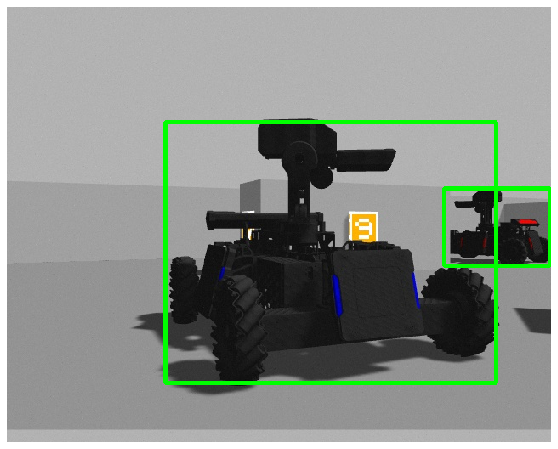

In [60]:
idx = 103
boxes = results[idx]['boxes']
image = cv2.imread(f'{DIR_IMAGE}/'+results[idx]['image_id']+'.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(image,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 150, 0), 3)
    
ax.set_axis_off()
ax.imshow(image)

In [64]:
out_df.to_csv("output.csv", index=False)